Word embeddings are used to deal with a disadvantage of the tradiitional way of treating words as discrete atomic symbols in natural language processing. We will follow this tutorial: https://www.tensorflow.org/tutorials/word2vec to learn a basic implementation of vector represenation of words in TensorFlow

The idea is to embedd the discrete set of words into a continuous vector space, where the distance between two words is proportional to their semantic similarity. Semantic similarity of two words in turn will be measured by how often these two words appear in the same context.

Word2Vec is a predictive model for learning word embeddings from raw text. It supports the CBO model, which predicts target words given a context and the Skip-Gram model (http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) which context from target word.

Under the hood, these algorithms use the maximum likelihood principle and use the softmax function on the history. This model also uses stochastic gradient descent, it would be interesting to try Levenberg-Marquardt or BFGS algorithms and compare performance and results.

In [66]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile
import io

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

We will now load the tweets of a single user. These tweets area already extracted in one txt file and preprocessed, i.e. stopwords are removed, emojis are removed and a stemming algorithm was applied.

In [67]:
tweets = open('filtered.txt','r', encoding="utf8")

In [68]:
vocabulary = tweets.read()

In [69]:
vocabulary

' RT @hbarnes: My bro @jjbareapr start fund help peopl Puerto Rico affect #HurricaneMaria RT @BEDGEAR: 100% 9/16 onlin sale benefit Houston. Work w/ @swish41, @dallasmav &amp; @mcuban match donations. I\'m stiff day ex teammat Darrel Armstrong call favorit nicknam time: "The big mummy" Rafaaaa Congrat @SloaneStephen RT @DBB_Basketball: Wenn Selbstbewusstsein, auf Willen, Einsatz und Können trifft, dann kommt das dabei raus - 84:81 im Achtelfinale. #GERF… Great news! @mcuban match proceed Sept.16 tenni tourney $2 million! Amazing! RT @FORTyONEmagazin: Der Philosoph Gunter Gebauer über @swish41, Holger Geschwindn und Karl Adam: "Zwei Erfinder" auf @FORTyONEmagazin! h… I’ve decid proceed Sept. 16 tenni tourney go direct famili kid affect Hu… My thought affect terribl flood caus Hurrican Harvey! My heart you! Congrats, Pudge!!! Thank South Africa us. We great time. Nba Africa game 2017 success! I loos yet..... Huge congrat Adrian Beltre!!!! Respect! #Beltre3k Everyon post pic workouts! So 

In [70]:
type(vocabulary)
vocabulary = vocabulary.split()

In [71]:

print('Data size', len(vocabulary))

# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 5000


Data size 18210


In [72]:

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1)) # list of tupels (word, # of occurences) that appear at least n_words times, anything else is rare and thus will be replaced by unk token
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary) # give them consecutive ids, maybe faster to not always compute len ???
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0) #returns word_count; the 0 means that it will return 0 if word is not found
    if index == 0:  # dictionary['UNK'], i.e. word does not exist in dictionary
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary


In [73]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 1096], ('Im', 1750), ('Twitter!', 1745), ('RT', 302), ('@swish41', 225)]
Sample data [3, 1827, 41, 518, 519, 54, 1828, 235, 302, 1829] ['RT', '@hbarnes:', 'My', 'bro', '@jjbareapr', 'start', 'fund', 'help', 'peopl', 'Puerto']


In [74]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      for word in data[:span]:
        buffer.append(word)
      #buffer[:] = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

1827 @hbarnes: -> 41 My
1827 @hbarnes: -> 3 RT
41 My -> 518 bro
41 My -> 1827 @hbarnes:
518 bro -> 519 @jjbareapr
518 bro -> 41 My
519 @jjbareapr -> 54 start
519 @jjbareapr -> 518 bro


In [75]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [76]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

In [79]:
num_steps = 25000

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val
    if step % 500 == 0:
        print(step)
    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if  step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 4  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[np.int32(nearest[k])]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
0
Average loss at step  0 :  179.070159912
Nearest to I: I, massiv, $10, love.,
Nearest to like: like, DO, goes:, team?”,
Nearest to time: time, icon..., rock., caron,,
Nearest to One: One, Besserung,, Chris, "Nowitzki,
Nearest to team: team, #Champions4Charity“, vielseitig, Das,
Nearest to it.: it., euros., bis, interested.”,
Nearest to think: think, late, “@BryceWIT:, might,
Nearest to us: us, dominant., host, seid,
Nearest to What: What, sure, heart, @SwansOfficial:,
Nearest to Twitter!: Twitter!, Turnier, MFFL, dez,
Nearest to Tough: Tough, #MavsFansAreBett, like, natürlich,
Nearest to Congrat: Congrat, @maverick, Chase, Winner,
Nearest to Auf: Auf, “@iTweetDaPUSSy:, appreciated...., Ticketmaster!,
Nearest to My: My, too!, Shot",, Fitnesszustand,
Nearest to 2: 2, @SwansOfficial:, Say, hilft?,
Nearest to fan: fan, meetin, begin., naechsten,
500
1000
1500
2000
Average loss at step  2000 :  24.3115054893
2500
3000
3500
4000
Average loss at step  4000 :  3.50819688308
4500


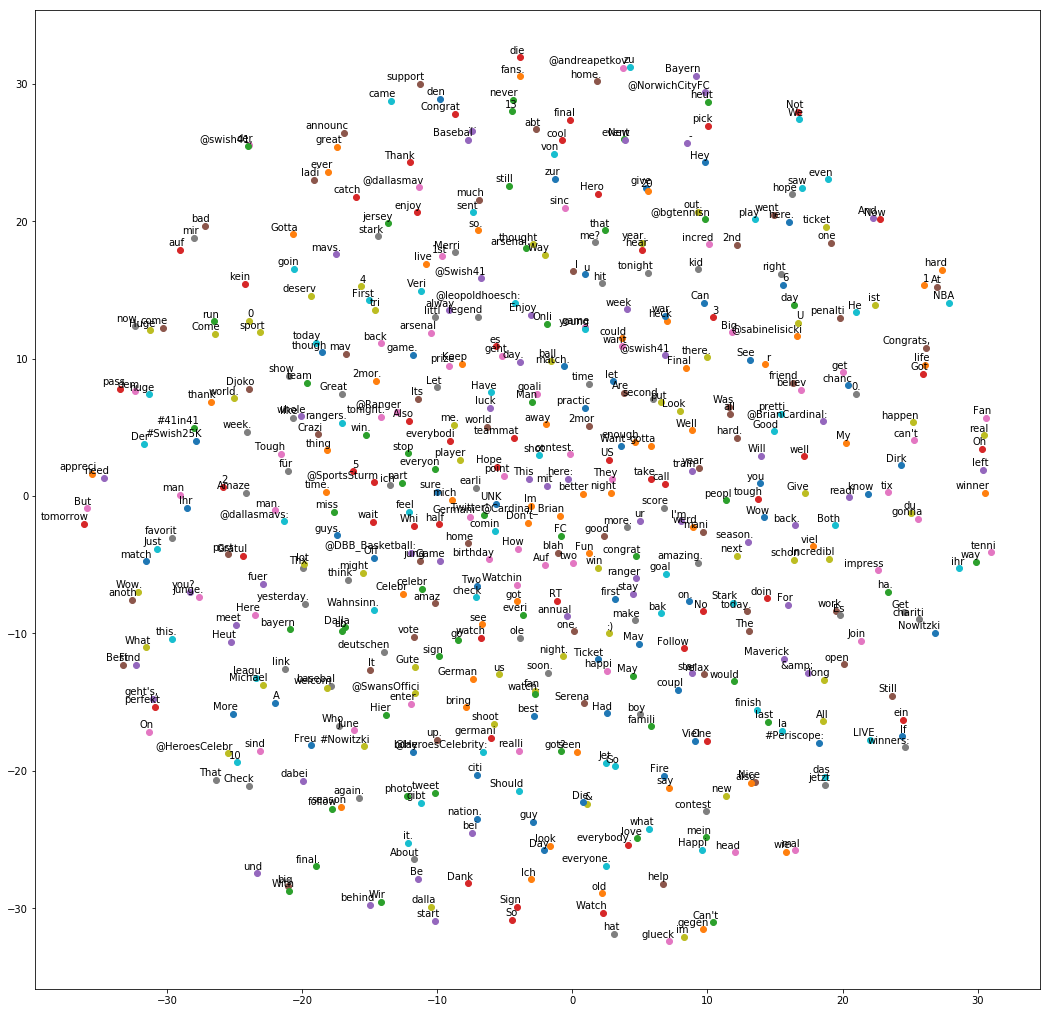

In [80]:
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)